# Property Maintenance Fines 

**Predicting the probability that a set of blight tickets will be paid on time**

**Supervised Learning. Classification**

Source: [Applied Machine Learning in Python | Coursera](https://www.coursera.org/learn/python-machine-learning). Solved with classical machine learning classifiers [here](https://github.com/angelmtenor/applied-ML-coursera/blob/master/4_property_maintenance_fines.ipynb)

Data provided by Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)), the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) and the City of Detroit [Detroit Open Data Portal](https://data.detroitmi.gov/).
 

Each row of the dataset   corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. 

**Features**
    
    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
** Labels **

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction]
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant

In [1]:
import os, sys
import numpy as np
import pandas as pd

import ds_boost
from tensorflow import keras

log = ds_boost.logger.init(level="DEBUG", save_log=False)

ds_boost.set_parent_execution_path()
ds_boost.info_system()
# sns.set_palette("GnBu_d")
# ds_boost.reproducible(seed=0) # Setup reproducible results from run to run using Keras

%matplotlib inline

23:18:42 - DEBUG 	 Path changed to /home/angel/DRIVE/0_repos/data-science-keras
23:18:42 - DEBUG 	 HARDWARE:
23:18:43 - DEBUG 	 CPU:	Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz
23:18:43 - DEBUG 	 RAM:	15 GB
23:18:43 - DEBUG 	 -- No GPU  --
23:18:43 - DEBUG 	 OS:	Linux-5.15.0-57-generic-x86_64-with-glibc2.35
23:18:43 - DEBUG 	 ENV:	/home/angel/miniconda3/envs/ds-keras
23:18:43 - DEBUG 	 PYTHON:	3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]
23:18:43 - DEBUG 	 tensorflow                   2.11.0
23:18:43 - DEBUG 	 pandas                        1.5.2
23:18:43 - DEBUG 	 numpy                        1.24.1
23:18:43 - DEBUG 	 EXECUTION PATH: /home/angel/DRIVE/0_repos/data-science-keras
23:18:43 - DEBUG 	 EXECUTION DATE: Mon Jan 16 23:18:43 2023


##  1. Data Processing

In [2]:
data_path = "data/property_maintenance_fines_data.parquet"
target = ["compliance"]

# df_original = pd.read_csv(data_path, encoding="iso-8859-1", dtype="unicode")
df_original = pd.read_parquet(data_path)  # , encoding="iso-8859-1", dtype="unicode")

print("{} rows \n{} columns \ntarget: {}".format(*df_original.shape, target))

250306 rows 
34 columns 
target: ['compliance']


In [3]:
# df_original.to_parquet("data/property_maintenance_fines_data.parquet")

### Explore and Clean the target

In [4]:
print(df_original[target].squeeze().value_counts(dropna=False))

0.0     148283
None     90426
1.0      11597
Name: compliance, dtype: int64


In [5]:
# Remove rows with NULL targets

df_original = df_original.dropna(subset=target)

print(df_original[target].squeeze().value_counts())
print(df_original.shape)

0.0    148283
1.0     11597
Name: compliance, dtype: int64
(159880, 34)


**Imbalanced target: the evaluation metric used in this problem is the Area Under the ROC Curve**

###  Split original data into training and validation test set

In [6]:
from sklearn.model_selection import train_test_split

df, df_test = train_test_split(df_original, test_size=0.2, stratify=df_original[target], random_state=0)

**To avoid data leakage, only the training dataframe, df, will be explored and processed here** 

### Show the training data

In [7]:
df.head(2)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
131030,159232,Department of Public Works,"Montgomery-Coit, Kimberlye","JOHNSON-GREENE, MARGUSIE F.",11645.0,LAKEPOINTE,None,11645,LAKEPOINTE,DETROIT,...,0.0,85.0,85.0,0.0,2008-09-12 00:00:00,PAID IN FULL,None,None,non-compliant by late payment more than 1 month,0.0
29573,49039,"Buildings, Safety Engineering & Env Department","Watson, Jerry","BAPT CHURCH, HOLY TABERNACLE",3184.0,CANFIELD,None,3184,E. CANFIELD,DETROIT,...,0.0,305.0,305.0,0.0,2007-06-26 00:00:00,PAID IN FULL,None,None,non-compliant by late payment more than 1 month,0.0


#### Missing values

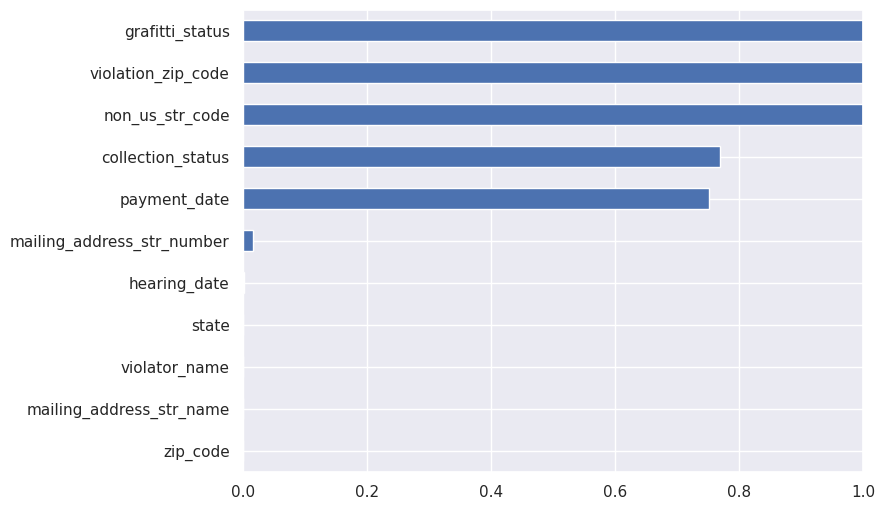

In [8]:
ds_boost.missing(df)

### Transform Data

#### Remove irrelevant features

In [9]:
def remove_features(df):

    relevant_col = [
        "agency_name",
        "violation_street_name",
        "city",
        "state",
        "violator_name",
        "violation_code",
        "late_fee",
        "discount_amount",
        "judgment_amount",
        "disposition",
        "fine_amount",
        "compliance",
    ]
    df = df[relevant_col]

    return df


df = remove_features(df)

print(df.shape)

(127904, 12)


#### Classify variables

In [10]:
num = ["late_fee", "discount_amount", "judgment_amount", "fine_amount"]

df = ds_boost.sort_columns_by_type(df, target, numerical=num)

pd.DataFrame(dict(df.dtypes), index=["Type"])[df.columns].head()  # show data types

23:18:46 - DEBUG 	 4 numerical features: 	 ['late_fee', 'discount_amount', 'judgment_amount', 'fine_amount']
23:18:46 - DEBUG 	 7 categorical features: 	 ['disposition', 'agency_name', 'city', 'violator_name', 'violation_street_name', 'state', 'violation_code']
23:18:46 - DEBUG 	 Target: 		compliance (object)


,late_fee,discount_amount,judgment_amount,fine_amount,disposition,agency_name,city,violator_name,violation_street_name,state,violation_code,compliance
Type,float32,float32,float32,float32,category,category,category,category,category,category,category,object


#### Remove low-frequency categorical values

In [11]:
df, dict_categories = ds_boost.remove_categories(df, target=target, ratio=0.001, show=False)

23:18:46 - DEBUG 	 Variables changed to 'category': {columns_to_convert}
23:18:46 - DEBUG 	 Removing 3595 categories from feature city
23:18:46 - DEBUG 	 Removing 72749 categories from feature violator_name
23:18:46 - DEBUG 	 Removing 1377 categories from feature violation_street_name
23:18:46 - DEBUG 	 Removing 39 categories from feature state
23:18:46 - DEBUG 	 Removing 151 categories from feature violation_code


####  Fill missing values

Missing categorical values filled by 'Other'
There are no numerical missing values

In [12]:
df = ds_boost.fill_simple(df, target, missing_categorical="Other")

23:18:46 - DEBUG 	 Missing categorical filled with label: "Other"


In [13]:
ds_boost.missing(df);

23:18:46 - DEBUG 	 No missing values found


### Visualize the data

#### Categorical features

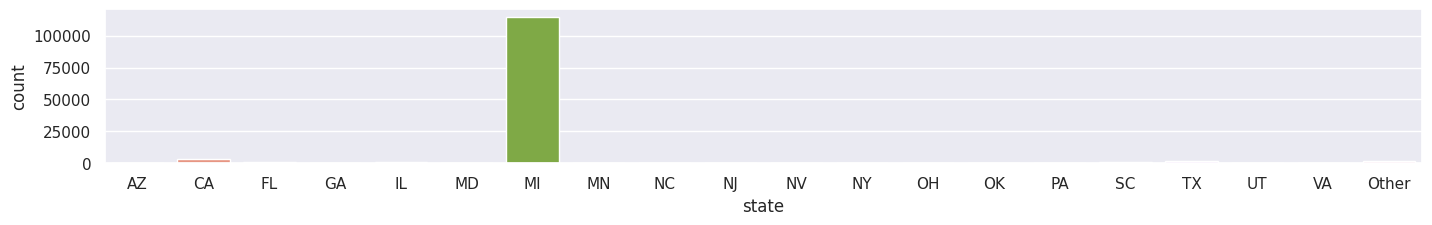

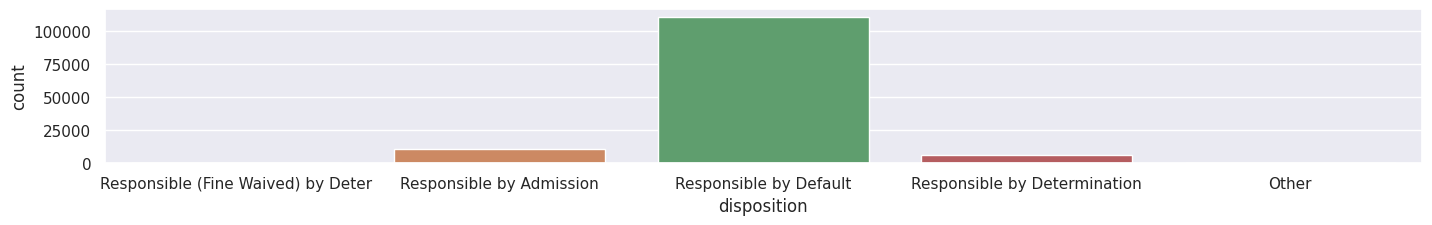

In [14]:
for i in ["state", "disposition"]:
    ds_boost.show_categorical(df[[i]])

#### Target vs Categorical features

In [15]:
# for i in ["state", "disposition"]:
#     ds_boost.show_target_vs_categorical(df[[i, target[0]]], target) # TODO Fix

#### Numerical features

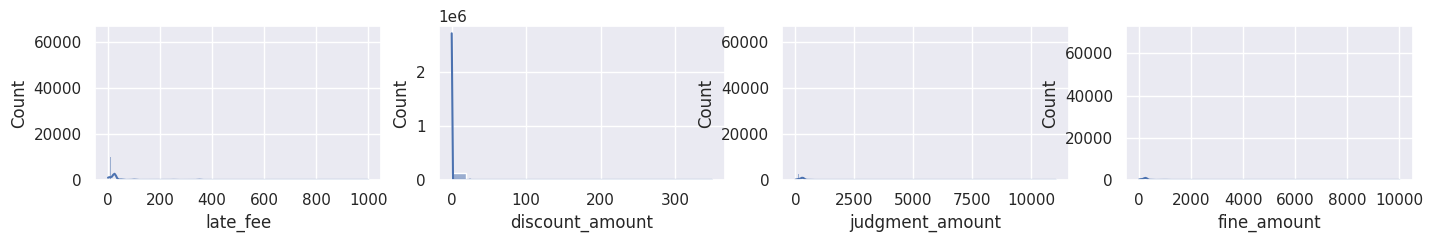

In [16]:
ds_boost.show_numerical(df, kde=True)

#### Target vs Numerical features

In [17]:
# ds_boost.show_target_vs_numerical(df, target, point_size=10, jitter=0.3, fit_reg=True)
# plt.ylim(ymin=-0.2, ymax=1.2)  # TODO: Optimize (high computation)

#### Correlation between numerical features and target

/home/angel/DRIVE/0_repos/data-science-keras/src/ds_boost/ds_boost.py:778: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = copy_df.corr().loc[numerical_f, target].fillna(0).sort_values(target, ascending=False).round(2)


[]

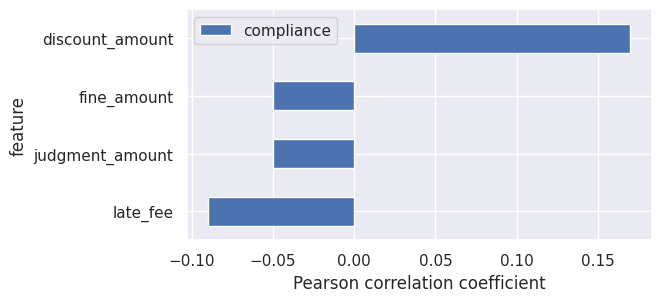

In [18]:
ds_boost.correlation(df, target, figsize=(6, 3))

## 2. Neural Network Model

### Select the features

In [19]:
droplist = []  # features to drop

# For the model 'data' instead of 'df'
data = df.copy()
# del(df)
data.drop(droplist, axis="columns", inplace=True)
data.head(2)

,late_fee,discount_amount,judgment_amount,fine_amount,disposition,agency_name,city,violator_name,violation_street_name,state,violation_code,compliance
131030,5.0,0.0,85.0,50.0,Responsible by Determination,Department of Public Works,DETROIT,Other,LAKEPOINTE,MI,9-1-103(C),0.0
29573,25.0,0.0,305.0,250.0,Responsible by Default,"Buildings, Safety Engineering & Env Department",DETROIT,Other,Other,MI,9-1-36(a),0.0


### Scale numerical variables
Shift and scale numerical variables to a standard normal distribution. The scaling factors are saved to be used for predictions.

In [20]:
data, scale_param = ds_boost.scale(data)

### Create dummy features
Replace categorical features (no target) with dummy features

In [21]:
data, dict_dummies = ds_boost.replace_by_dummies(data, target)

model_features = [f for f in data if f not in target]  # sorted neural network inputs

data.head(3)

,late_fee,discount_amount,judgment_amount,fine_amount,compliance,disposition_Responsible (Fine Waived) by Deter,disposition_Responsible by Admission,disposition_Responsible by Default,disposition_Responsible by Determination,disposition_Other,...,violation_code_9-1-105,violation_code_9-1-110(a),violation_code_9-1-206,violation_code_9-1-209,violation_code_9-1-36(a),violation_code_9-1-43(a) - (Dwellin,violation_code_9-1-43(a) - (Structu,violation_code_9-1-81(a),violation_code_9-1-82(d) - (Dwellin,violation_code_Other
131030,-0.422306,-0.049474,-0.451255,-0.453714,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
29573,-0.126339,-0.049474,-0.154289,-0.156975,0.0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2657,-0.126339,-0.049474,-0.154289,-0.156975,0.0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


### Split the data into training and validation sets

In [22]:
val_size = 0.2
random_state = 0


def validation_split(data, val_size=0.25):

    train, test = train_test_split(data, test_size=val_size, random_state=random_state, stratify=data[target])

    # Separate the data into features and target (x=features, y=target)
    x_train, y_train = train.drop(target, axis=1).values, train[target].values
    x_val, y_val = test.drop(target, axis=1).values, test[target].values
    # _nc: non-categorical yet (needs one-hot encoding)

    return x_train, y_train, x_val, y_val


x_train, y_train, x_val, y_val = validation_split(data, val_size=val_size)

# x_train = x_train.astype(np.float16)
y_train = y_train.astype(np.float16)
# X_val = x_val.astype(np.float16)
y_val = y_val.astype(np.float16)

### Encode the output

In [23]:
def one_hot_output(y_train, y_val):
    num_classes = len(np.unique(y_train))
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    return y_train, y_val


y_train, y_val = one_hot_output(y_train, y_val)

In [24]:
print("train size \t X:{} \t Y:{}".format(x_train.shape, y_train.shape))
print("val size \t X:{} \t Y:{}".format(x_val.shape, y_val.shape))

train size 	 X:(102323, 445) 	 Y:(102323, 2)
val size 	 X:(25581, 445) 	 Y:(25581, 2)


### Build a dummy classifier

In [25]:
ds_boost.dummy_clf(x_train, y_train[:, 1], x_val, y_val[:, 1])

23:19:12 - DEBUG 	 Confusion matrix: 
 [[23725     0]
 [ 1856     0]]


,Loss,Accuracy,Precision,Recall,ROC-AUC,F1-score
Dummy,1.16,0.93,0.0,0,0,0


### Build a random forest classifier (best of grid search)

In [26]:
from sklearn.ensemble import RandomForestClassifier


%time clf_random_forest_opt = RandomForestClassifier(n_estimators = 30, max_features=150, \
                                max_depth=13, class_weight='balanced', n_jobs=-1, \
                                   random_state=0).fit(x_train, np.ravel(y_train[:,1]))

CPU times: user 1min 59s, sys: 455 ms, total: 1min 59s
Wall time: 18 s


In [27]:
y_pred = clf_random_forest_opt.predict(x_val).reshape([-1, 1])
ds_boost.binary_classification_scores(y_val[:, 1], y_pred);

23:19:31 - DEBUG 	 Confusion matrix: 
 [[21173  2552]
 [  730  1126]]


### Build the Neural Network for Binary Classification

In [28]:
cw = ds_boost.get_class_weight(y_train[:, 1])  # class weight (imbalanced target)

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout


def build_nn(input_size, output_size, summary=False):

    input_nodes = input_size // 8

    model = Sequential()
    model.add(Dense(input_nodes, input_dim=input_size, activation="relu"))

    model.add(Dense(output_size, activation="softmax"))

    if summary:
        model.summary()

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model


model = build_nn(x_train.shape[1], y_train.shape[1], summary=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 55)                24530     
                                                                 
 dense_1 (Dense)             (None, 2)                 112       
                                                                 
Total params: 24,642
Trainable params: 24,642
Non-trainable params: 0
_________________________________________________________________


### Train the Neural Network

Training ....
Epoch 1/100
35/35 [==============================] - 1s 17ms/step - loss: 0.6584 - accuracy: 0.7086 - val_loss: 0.6157 - val_accuracy: 0.7166
Epoch 2/100
35/35 [==============================] - 0s 10ms/step - loss: 0.5845 - accuracy: 0.7405 - val_loss: 0.5459 - val_accuracy: 0.7867
Epoch 2: early stopping
time: 	 2.0 s


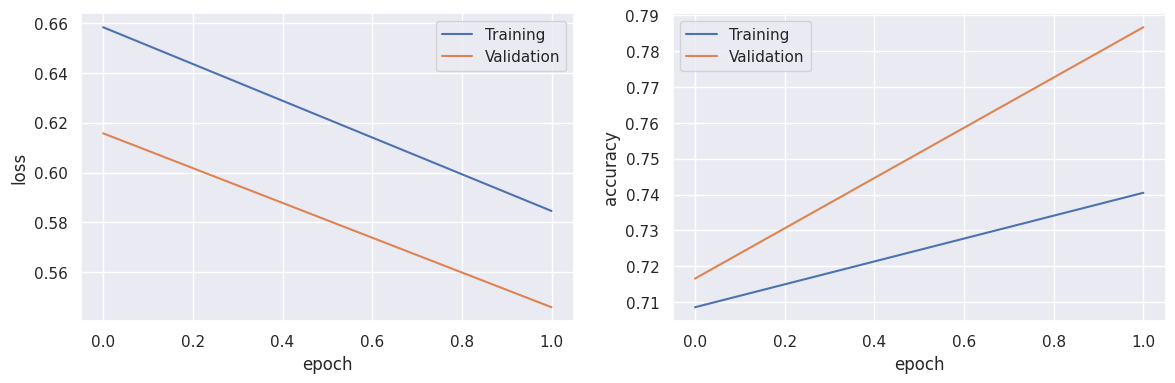

23:19:33 - DEBUG 	 Training loss:  	0.5845
23:19:33 - DEBUG 	 Validation loss: 	 0.5459
23:19:33 - DEBUG 	 Training accuracy: 	0.741
23:19:33 - DEBUG 	 Validation accuracy:	0.787
3198/3198 [==============================] - 4s 1ms/step


 ROC_AUC train:	0.80 

800/800 [==============================] - 1s 1ms/step


 ROC_AUC val:	0.80


In [29]:
import os
from time import time

model_path = os.path.join("models", "detroit.h5")


def train_nn(model, x_train, y_train, validation_data=None, path=False, show=True):
    """
    Train the neural network model. If no validation_data is provided, a split for validation
    will be used
    """

    if show:
        print("Training ....")

    callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=0, verbose=1)]
    t0 = time()

    history = model.fit(
        x_train,
        y_train,
        epochs=100,
        batch_size=2048,
        class_weight=cw,
        verbose=1,
        validation_split=0.3,
        validation_data=validation_data,
        callbacks=callbacks,
    )

    if show:
        print("time: \t {:.1f} s".format(time() - t0))
        ds_boost.show_training(history)

    if path:
        model.save(path)
        print("\nModel saved at", path)

    return history


model = None
model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
train_nn(model, x_train, y_train, path=None)


from sklearn.metrics import roc_auc_score

y_pred_train = model.predict(x_train, verbose=1)
print("\n\n ROC_AUC train:\t{:.2f} \n".format(roc_auc_score(y_train, y_pred_train)))
y_pred_val = model.predict(x_val, verbose=1)
print("\n\n ROC_AUC val:\t{:.2f}".format(roc_auc_score(y_val, y_pred_val)))

### Validate the model (validation set)

In [30]:
ds_boost.binary_classification_scores(y_val[:, 1], y_pred_val[:, 1], return_dataframe=True)

23:19:41 - DEBUG 	 Confusion matrix: 
 [[19058  4667]
 [  616  1240]]


,Loss,Accuracy,Precision,Recall,ROC-AUC,F1-score
,0.5,0.79,0.21,0.67,0.8,0.32


### Evaluate the final model (test set)

In [31]:
df_test.head(2)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
29156,48696,Department of Public Works,"Funchess, Mitchell","CORP, CONTIMORTGAGE",8200.0,HEYDEN,None,3815,WEST TEMPLE,SALT LAKE CITY,...,0.0,140.0,0.0,140.0,None,NO PAYMENT APPLIED,IN COLLECTION,None,non-compliant by no payment,0.0
125262,152329,"Buildings, Safety Engineering & Env Department","Doetsch, James","JACKSON, THEO",13821.0,GLENWOOD,None,1464,PO BOX,DETROIT,...,0.0,305.0,0.0,305.0,None,NO PAYMENT APPLIED,None,None,non-compliant by no payment,0.0


#### Process test data with training set parameters (no data leakage)

In [32]:
df_test = remove_features(df_test)
df_test = ds_boost.sort_columns_by_type(df_test, target, numerical=num)
df_test, _ = ds_boost.remove_categories(df_test, target=target, show=False, dict_categories=dict_categories)
df_test = ds_boost.fill_simple(df_test, target, missing_categorical="Other")
df_test, _ = ds_boost.scale(df_test, scale_param)
df_test, _ = ds_boost.replace_by_dummies(df_test, target, dict_dummies)
df_test = df_test[model_features + target]  # sort columns to match training features order

23:19:41 - DEBUG 	 4 numerical features: 	 ['late_fee', 'discount_amount', 'judgment_amount', 'fine_amount']
23:19:41 - DEBUG 	 7 categorical features: 	 ['disposition', 'agency_name', 'city', 'violator_name', 'violation_street_name', 'state', 'violation_code']
23:19:41 - DEBUG 	 Target: 		compliance (object)
23:19:41 - DEBUG 	 Variables changed to 'category': {columns_to_convert}
23:19:41 - DEBUG 	 Missing categorical filled with label: "Other"


In [33]:
def separate_x_y(data):
    """Separate the data into features and target (x=features, y=target)"""

    x, y = data.drop(target, axis=1).values, data[target].values
    x = x.astype(np.float16)
    y = y.astype(np.float16)

    return x, y


x_test, y_test = separate_x_y(df_test)

y_test = keras.utils.to_categorical(y_test, 2)

####  Random Forest model

In [34]:
y_pred = clf_random_forest_opt.predict_proba(x_test)
ds_boost.binary_classification_scores(y_test[:, 1], y_pred[:, 1], return_dataframe=True)

23:19:43 - DEBUG 	 Confusion matrix: 
 [[26456  3201]
 [  955  1364]]


,Loss,Accuracy,Precision,Recall,ROC-AUC,F1-score
,0.46,0.87,0.3,0.59,0.81,0.4


,Importance
late_fee,0.29
disposition_Responsible by Default,0.28
judgment_amount,0.09
disposition_Responsible by Admission,0.07
disposition_Responsible by Determination,0.05
fine_amount,0.02
discount_amount,0.02
violation_code_9-1-36(a),0.01
city_DETROIT,0.01
violation_code_22-2-61,0.01


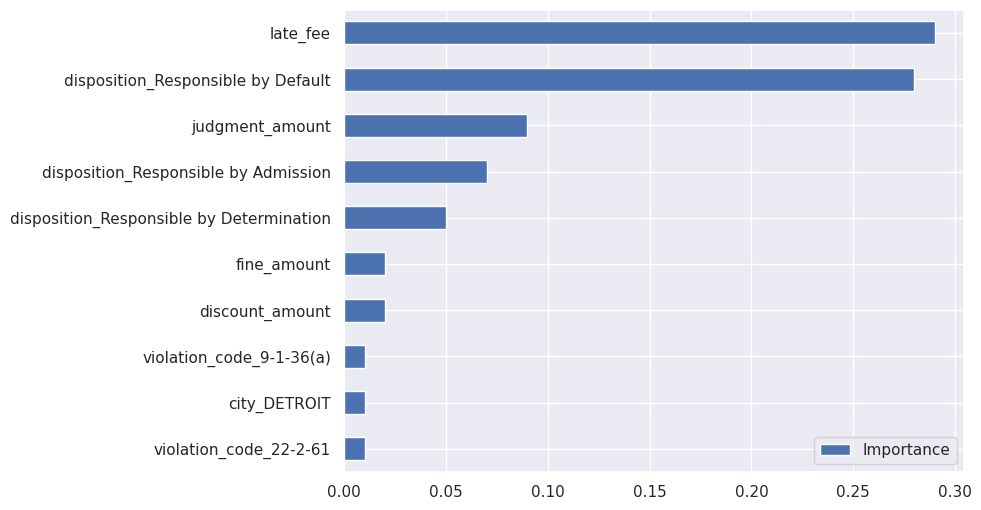

In [35]:
ds_boost.feature_importance(model_features, clf_random_forest_opt)

#### Neural Network model

In [36]:
y_pred = model.predict(x_test, verbose=1)[:, 1]
ds_boost.binary_classification_scores(y_test[:, 1], y_pred, return_dataframe=True)

1000/1000 [==============================] - 1s 1ms/step
23:19:45 - DEBUG 	 Confusion matrix: 
 [[23736  5921]
 [  786  1533]]


,Loss,Accuracy,Precision,Recall,ROC-AUC,F1-score
,0.5,0.79,0.21,0.66,0.79,0.31


### Compare with other non-neural ML models

In [37]:
ds_boost.ml_classification(x_train, y_train[:, 1], x_test, y_test[:, 1])

23:19:45 - DEBUG 	 Naive Bayes
23:19:47 - DEBUG 	 Random Forest
23:19:55 - DEBUG 	 Extremely Randomized Trees
23:20:04 - DEBUG 	 LGBM


,Time (s),Loss,Accuracy,Precision,Recall,ROC-AUC,F1-score
LGBM,1.12,0.19,0.94,0.90,0.24,0.81,0.38
Random Forest,7.29,0.20,0.94,0.93,0.22,0.81,0.35
Extremely Randomized Trees,8.87,0.21,0.93,0.99,0.03,0.81,0.06
Naive Bayes,1.25,21.65,0.36,0.09,0.83,0.59,0.16
